# Tarea 2
## Francisco Javier Peralta Ramírez

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from numba import jit
import time
import numpy as np
import sympy as sp
from functools import reduce
from sklearn import datasets


import warnings
sp.init_printing()
iris = datasets.load_iris()
warnings.filterwarnings('ignore')

El algoritmo de regresión logistica es un clasificador binario para clases linealmente separables. La idea del algoritmo es poner una sigmoide sobre los datos de tal modo que el valor de cada dato, al evaluarse sobre la sigmoide representa la probabilidad de que pertenezca a la clase 1 es decir $P( Y = 1 | X = x ) $. La funcion sigmoide es:

$$ \phi(x) = \frac{1}{1 + e^{-z}}$$

Esta función tiene la siguiente forma en $\mathbb{R}^1$

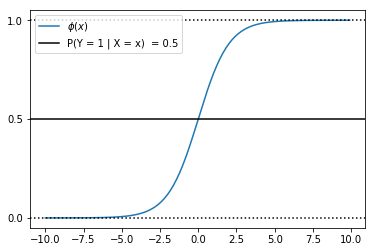

In [2]:
def sigmoid(x, lib=np):
    return 1/(1 + lib.exp(-x))
v = np.arange( -10, 10, 0.1)
plt.plot( v, sigmoid( v) , label="$\phi(x)$")
plt.axhline(0.0, ls='dotted', color='k')
plt.axhline(1.0, ls='dotted', color='k')
plt.axhline(0.5, color='k', label="P(Y = 1 | X = x)  = 0.5")
plt.yticks([0, 0.5, 1])
plt.legend()
plt.show()

Consideremos el caso simple de separar datos de dos Gaussianas

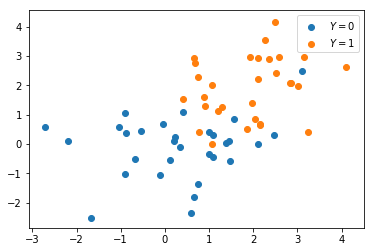

[1.11297587 0.91246196]


In [3]:
n_samples = 30
x1 = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0, 1]]), n_samples)
x2 = np.random.multivariate_normal(np.array([2,2]), np.array([[1,0], [0, 1]]), n_samples)

x = np.append(x1, x2, axis = 0)
# x = x - x.mean(axis=0) #centramos los datos para acelerar la convergencia
y = np.append([0] * len(x1) , [1] * len(x2)) # creamos nuestro vector de Y

plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$")
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$")
plt.legend()
plt.show()

print(x.mean(axis=0))

Podemos hacer el ajuste de esta sigmoide minimizando el error de clasificación

$$ \min_{w}F(w) = \frac{1}{2} \sum_{i=1}^{m} (y_i - \phi(\mathbf{w}^T\mathbf{x}_i))^2 $$

donde $\mathbf{w}$ es un vector de pesos y $\mathbf{x}_i$ es nuestra variable en $\mathbb{R}^n$. Esto lo podemos resolver con el métdo de gradiente desendiente con la actualización en cada iteración

\begin{align}
\mathbf{w} &= \mathbf{w} - \alpha \sum_{i=0}^m r_i(\mathbf{w}) \nabla r_i(\mathbf{w})\\
&= \mathbf{w} - \alpha J(\mathbf{w}) r(\mathbf{w})
\end{align}

donde $r_i = y_i - \phi(\mathbf{w}^T\mathbf{x}_i)$ y $J_i = \nabla r_i$. Podemos ver que 
$$
J_{ij} = \frac{\partial r_i}{\partial w_j} =  - \frac{\partial \phi(\mathbf{w}^T\mathbf{x}_i)}{\partial w_j} x_{i,j}$$ Donde 

\begin{align}
\frac{\partial{\phi(z)}}{\partial{z}} &= \frac{e^{-z}}{ (1 + e ^ {-z})^2}\\
&= \left(\frac{1}{1 + e^{-z}}\right)\left(\frac{1 - 1 + e^{-z}}{1 + e^{-z}}\right)\\
&= \phi(z)[1-\phi(z)]
\end{align}

Por lo cual
$$
\frac{\partial r_i}{\partial w_j} = - \phi(\mathbf{w}^T\mathbf{x}_i)[1 - \phi(\mathbf{w}^T\mathbf{x}_i)] x_{i,j}
$$

In [4]:
def logistic_function(x, w, lib=np):
    v = w[0]
    for i in range(len(x)):
        v += w[i+1] * x[i]
    return sigmoid(v, lib)
def R_sigmoid(y, x, w, lib=np):
    return y - logistic_function(x, w, lib=lib)

def __jacobiano_sigmoid(f, y, x, w):
    w_s = sp.symbols("w0:{}".format(len(w)))
    x_s = sp.symbols("x0:{}".format(len(w) - 1))
    y_s = sp.Symbol("y")
    mtx = sp.Matrix([f( y_s , x_s, w_s , lib=sp)]) #el reduce nos da la suma de todas las w[i]
    jac = mtx.jacobian(w_s)
    jac_f  = [sp.lambdify((x_s + w_s), jac[i]) for i in range(len(w))]
    def __do_grad(w):
        jac_eval = [ [jac_fn(*xi, *w) for jac_fn in jac_f] for xi in x]
        return np.array(jac_eval)
    return __do_grad

def __max_diag(A): #valor maximo en diagonal de matriz cuadrada
    l = A[0,0]
    for i in range(1, len(A)):
        l = A[i,i] if(A[i,i] > l) else l
    return l

In [5]:
def __R(y, x, w, lib=np):
    return np.array([ R_sigmoid(y[i], x[i], w, lib=lib) for i in range(len(x))])

def __grad_desc(R, J,  x, y, w, a=1, m=1.2, mk=100, toler = 1E-10):
    k = 0
    r = R(y, x, w)
    j = J(w)
    norm_sq_r = r.T @ r
    b = j.T @r
    ws = []
    tm = []
    start = time.time()
    while np.linalg.norm( b ) and k < mk:
        k = k + 1
        nw = w - a * b
        nr = R(y, x, nw)
        if( nr @ nr > r @ r):
            a /= m
            if(a < 1E-10): break
        else:
            r = nr
            w = nw
            j = J(w)
            b = j.T @r
        ws.append(w)
        tm.append(time.time() - start)
    return w, ws, tm

In [6]:
%%time
def rl_ls(y, x, k=1000): #encapsulamos la funcion para reusar facil
    w = np.append([0], [1] * x.shape[1])
    jf = __jacobiano_sigmoid(R_sigmoid, y, x, w)
    return __grad_desc(__R, jf, x, y, w, mk=k)
w, ws, t = rl_ls(y, x)

CPU times: user 1.82 s, sys: 13.7 ms, total: 1.84 s
Wall time: 1.84 s


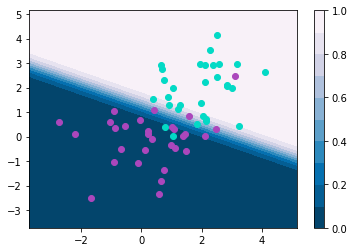

In [7]:
def eval_in_space(w, x):
    N = 100
    x_v = np.linspace(x.min()-1, x.max()+1, N)
    y_v = np.linspace(x.min()-1, x.max()+1, N)
    X_v, Y_v = np.meshgrid(x_v, y_v)
    XX = np.array([X_v.ravel(), Y_v.ravel()]).T
    Z = np.array([logistic_function(xi, w) for xi in XX])
    return X_v, Y_v, Z.reshape(X_v.shape)
X, Y, Z = eval_in_space(w, x)
cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples, 0], x[:n_samples, 1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:, 0], x[n_samples:, 1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

La regresión logistica también se puede hacer resolviendo el problema de optimizacíon dado por la función de máxima verosimilitud. Para esto consideramos que $p(y_i|\mathbf{x}_i ; \mathbf{w}) = y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i))$

donde $ x_i = [1, x_{i,0}, x_{i,1}, \cdots x_{i,m}]$

\begin{align}
L(\mathbf{w}) &= \prod_i^m p(y_i|\mathbf{x}_i ; \mathbf{w}) \\
&= \prod_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i))\\
&= \prod_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + [1 - \phi(\mathbf{w}^T\mathbf{x}_i)] - y_i + y_i\phi(\mathbf{w}^T\mathbf{x}_i)\\
&= \prod_{i = 0}^m  2y_i\phi(\mathbf{w}^T\mathbf{x}_i) - \phi(\mathbf{w}^T\mathbf{x}_i) - y + 1
\end{align}

Ya que el logaritmo es una función monotona, minimizar la verosimilitud y la log-verosimilitud es equivalente.

\begin{align}
\log(L(\mathbf{w})) = l(\mathbf{w}) &= \sum_{i=0}^m \log( 2y_i\phi(\mathbf{w}^T\mathbf{x}_i) - \phi(\mathbf{w}^T\mathbf{x}_i) - y + 1 )\\
\end{align}

In [8]:
def __verosimilitud__v1(y, x, w, f):
    l = 0
    for i in range(len(y)):
        fv = f(x[i], w)
        l += np.log(2*y[i] * fv - fv - y[i] + 1)
    return l

Derivamos con $w_j$

\begin{align}
\frac{\partial{l(\mathbf{w})}}{ \partial{w_j} } &= \sum_{i=0}^m \frac{2y_i \phi(\mathbf{w}^T\mathbf{x}_i) [1 - \phi(\mathbf{w}^T\mathbf{x}_i)] x_{ij} - \phi(\mathbf{w}^T\mathbf{x}_i) [1 - \phi(\mathbf{w}^T\mathbf{x}_i)] x_{ij}}{2y_i\phi(\mathbf{w}^T\mathbf{x}_i) - \phi(\mathbf{w}^T\mathbf{x}_i) + 1}\\
&= \sum_{i=0}^m \frac{\phi(\mathbf{w}^T\mathbf{x}_i) [1 - \phi(\mathbf{w}^T\mathbf{x}_i)] x_{ij} (2y_i - 1)}{2y_i\phi(\mathbf{w}^T\mathbf{x}_i) - \phi(\mathbf{w}^T\mathbf{x}_i) - y + 1}
\end{align}

In [9]:
def __grad_verosimilitud__v1(y, x, w, f):    
    gl = np.zeros_like(w)
    for i in range(len(y)):
        fx  = f(x[i], w)
        for j in range(len(w)):
            xij = np.append([1], x[i])[j]
            gl[j] += (2 * y[i] - 1) * fx * (1 - fx) * xij
    return np.array(gl)

In [10]:
#gradiente de descenso con backtracking
def gdb(w, f, gf, params, a=.01, m=1.5, k=1000):
    vw = f(w=w, **params) ## ** descomprime el diccionario
    ws = []
    tm = []
    start = time.time()
    for i in range(k):
        w1  = w + a * gf(w=w, **params) #como queremos maximizar, sumamos el gradiente en cada paso
        nvw = f(w=w1, **params)
        vw = nvw
        w = w1
        ws.append(w)
        tm.append(time.time() - start)
    return w, ws, tm

In [11]:
%%time
def rl_v1(y, x, k=1000): #podriamos exponer mas parametros...
    params = {'x':x, 'y':y, 'f':logistic_function}
    w = np.append([0], [1] * x.shape[1])
    w = gdb(w, 
            __verosimilitud__v1, 
            __grad_verosimilitud__v1,
            params, k=k)
    return w

w, ws, t = rl_v1(y, x)

CPU times: user 2.93 s, sys: 62.4 ms, total: 2.99 s
Wall time: 2.97 s


[-6.22551041  2.2284244   5.0515246 ]


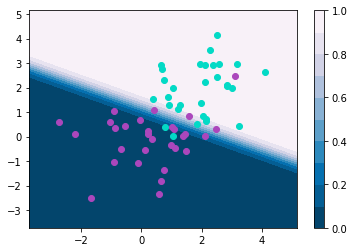

In [12]:
print(w)

X, Y, Z = eval_in_space(w, x)

cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

Como $y_i \in \{0,1\}$ es más sencillo si vemos $p(y_i|\mathbf{x}_i ; \mathbf{w}) = \phi(\mathbf{w}^T\mathbf{x}_i)^{y_i} + (1 - \phi(\mathbf{w}^T\mathbf{x}_i))^{1-y_i}$. Esto nos da 

$$L(w) =  \prod_{i = 0}^m  \phi(\mathbf{w}^T\mathbf{x}_i)^{y_i} + (1 - \phi(\mathbf{w}^T\mathbf{x}_i))^{(1 - y_i)}$$

dado que maximizar la verosimilitud equivale a maximizar la log-verosimilitud

$$\mathcal{l}(w) = \sum_{i = 0}^m  y_i\log(\phi(\mathbf{w}^T\mathbf{x}_i)) + (1 - y_i)\log[1 - \phi(\mathbf{w}^T\mathbf{x}_i)]$$

In [13]:
def __log_verosimilitud(y, x, w, f):
    l = 0
    for i in range(len(y)):
        fx = f(x[i], w)
        if(1-fx < 0):
            print ('error')
            break
        l += np.log(fx) if(y[i]) else 0 
        l += np.log(1 - fx) if (1 - y[i]) else 0
    return l

Para obtener las derivadas parciales, primero consideramos 

\begin{align}
\frac{\partial}{\partial(z)} (y \log\phi(z) + (1-y)log[1 - \phi(z)]) &= \left(\frac{y}{\phi(z)} - \frac{1-y}{1-\phi(z)}\right)\frac{\partial\phi(z_i)}{\partial{w_j}}\\
&= \left(\frac{y}{\phi(z)} - \frac{1-y}{1-\phi(z)}\right)\phi(z)[1 - \phi(z)]\\
&= y[1 - \phi(z)] - (1 - y)\phi(z)\\
&= y - \phi(z)
\end{align}

Con esto podemos econtrar más facilmente la derivada parcial

\begin{align}
    \frac{\partial l(\mathbf{w})}{\partial w_j} &= \sum_{i=0}^m \frac{\partial}{\partial(z)} (y \log\phi(z) + (1-y)log[1 - \phi(z)]) \frac{\partial z_i}{\partial w_j}\\
    &= \sum_{i=0}^m [y_i - \phi(\mathbf{x}_i^T\mathbf{w})]x_{ij}
\end{align}

In [14]:
def __grad_log_verosimilitud(y, x, w, f):
    gl = np.zeros_like(w)
    for i in range(len(y)):
        fx  = f(x[i], w)
        for j in range(len(w)):
            xij = np.append([1], x[i])[j]
            gl[j] += (y[i] - fx) * xij
    return np.array(gl)

In [15]:
def rl_v2(y, x, k=1000, a=1): #podriamos exponer mas parametros...
    params = {'x':x, 'y':y, 'f':logistic_function}
    w = np.append([0], [1] * x.shape[1])
    w = gdb(w,
            __log_verosimilitud, 
            __grad_log_verosimilitud,
            params, k=k, a=a)
    return w

[-2.64063652  0.89686706  1.98807675]
CPU times: user 2.63 s, sys: 30 ms, total: 2.66 s
Wall time: 2.65 s


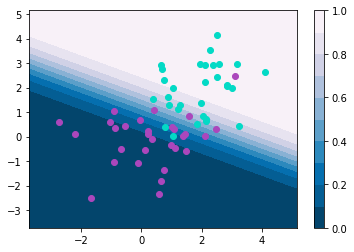

In [16]:
%%time
w, ws, t = rl_v2(y, x, a=.01)
print(w)

X, Y, Z = eval_in_space(w, x)

cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

Podemos comparar los resultados de los tres métodos de optimización. Para esto, consideramos las funciones de error

\begin{align}
\text{err}_1 &= \sum_{i=0}^m y_i \neq \lfloor\phi(\mathbf{w}^T\mathbf{x})\rceil \\
\text{err}_2 &= \sum_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i)) \\
\text{err}_3 &= \frac{1}{2} \sum_{i=1}^{m} (y_i - \phi(\mathbf{w}^T\mathbf{x}_i))^2
\end{align}

En la primera función penalizamos cada error con el mismo peso, mientras que en la segunda penalizamos más los errores más grandes, es decir, cuando clasificamos X como Y=1 con probabilidad alta

In [17]:
def err1(y, py):
    return sum(abs(y - np.round(np.array(py))))
def err2(y, py):
    err = 0
    for i in range(len(y)):
        err += y[i] * (1 - py[i]) + (1 - y[i]) * py[i]
    return err

def err3(y, py):
    err = 0
    for i in range(len(y)):
        err += (y[i] - py[i])**2
    return err

In [18]:
niter = 1000
w = rl_ls(y, x, k=niter)[0], rl_v1(y, x, k=niter)[0], rl_v2(y, x, k=niter,a=.01)[0]

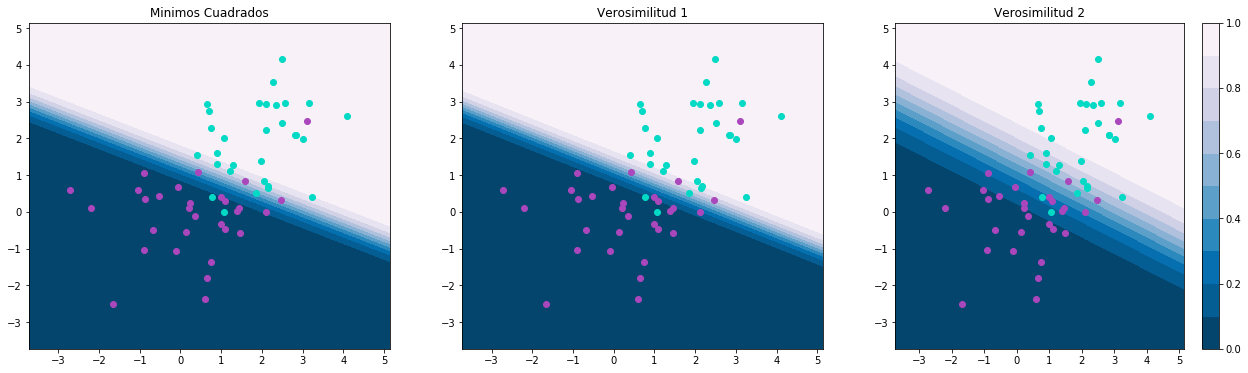

In [19]:
names = ['Minimos Cuadrados', "Verosimilitud 1", "Verosimilitud 2"]
f, ax = plt.subplots(1, len(w), figsize=(22, 6))
for i in range(len(w)):
    X, Y, Z = eval_in_space(w[i], x)
    cs = ax[i].contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
    ax[i].scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
    ax[i].scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
    ax[i].set_title(names[i])
plt.colorbar(cs)
plt.show()

In [20]:
py = [[logistic_function(xi, wi) for xi in x] for wi in w]
err1_v = [err1(y, pyi) for pyi in py]
err2_v = [err2(y, pyi) for pyi in py]
err3_v = [err3(y, pyi) for pyi in py]

for i in range(len(err1_v)):
    print(names[i], "\nError 1: ", err1_v[i], "Error 2:", err2_v[i], "Error 3:", err3_v[i])

Minimos Cuadrados 
Error 1:  6.0 Error 2: 7.060467832499538 Error 3: 4.383761495268476
Verosimilitud 1 
Error 1:  6.0 Error 2: 6.7379372518905205 Error 3: 4.577704662374962
Verosimilitud 2 
Error 1:  5.0 Error 2: 10.460288350935922 Error 3: 4.779637355361014


Como podemos ver, el desempeño es muy similar, pero el primer método de verosimilitud resulta superior.

------

Ya entendiendo el funcionamiento y viendo las gráficas en dos dimensiones, podemos usar datos en una dimensión más alta. Para este caso usaremos los datos de Iris (Fisher, 1936). En estos datos se tienen tres clases, pero se escogió la clase 0 y 2 ya que se sabe que estas no son linealmente separables, lo que elimina problemas de convergencia del algoritmo.

También se optó por normalizar los datos, esto es con la finalidad de acelerar la convergencia.

In [21]:
x_i = iris.data
y_i = iris.target
x_i = np.append(x_i[y_i == 1],x_i[y_i == 2], axis=0) # escogemos las clases 1 y 2
x_i -= x_i.mean(axis=0)
x_i /= x_i.var(axis=0)
y_i = np.append(y_i[y_i == 1],y_i[y_i == 2]) - 1 # -1 para cambiar las clases de (1, 2) a (0, 1)

In [22]:
%%time
niter = 200
res = rl_ls(y_i, x_i, k = niter), rl_v1(y_i, x_i, k = niter), rl_v2(y_i, x_i, k = niter, a = 0.01)

CPU times: user 3.7 s, sys: 40.9 ms, total: 3.74 s
Wall time: 3.73 s


In [23]:
res = np.array(res)
w_i, ws_i, t_i = res[:, 0], res[:, 1], res[:, 2]

Comparando las fronteras de decisión para las dos ultimas variables de nuestro vector de caracteristicas, observamos que todas son ligeramente diferentes y la frontera siempre es compacta.

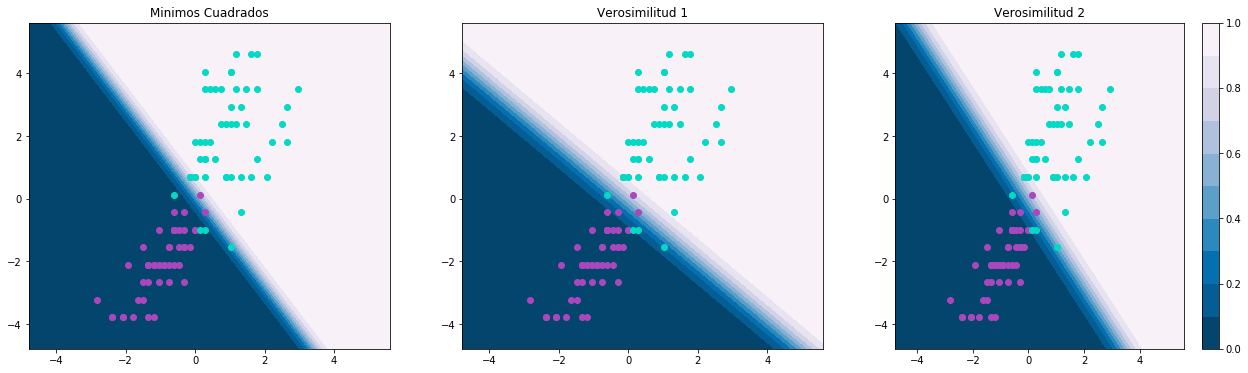

In [24]:
n_samples = 50
nx_i = x_i[:,2:]
names = ['Minimos Cuadrados', "Verosimilitud 1", "Verosimilitud 2"]
f, ax = plt.subplots(1, len(w_i), figsize=(22, 6))
for i in range(len(w_i)):
    nw_i = np.append(w_i[i][0], w_i[i][3:])
    X, Y, Z = eval_in_space(nw_i, nx_i)
    cs = ax[i].contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
    ax[i].scatter(nx_i[:n_samples,0], nx_i[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
    ax[i].scatter(nx_i[n_samples:,0], nx_i[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
    ax[i].set_title(names[i])
plt.colorbar(cs)
plt.show()

In [25]:
py = [[logistic_function(x_ii, wi) for x_ii in x_i] for wi in w_i]
err1_v = [err1(y_i, pyi) for pyi in py]
err2_v = [err2(y_i, pyi) for pyi in py]
err3_v = [err3(y_i, pyi) for pyi in py]
for i in range(len(err1_v)):
    print(names[i], "\nError 1: ", err1_v[i], "Error 2:", err2_v[i], "Error 3:", err3_v[i])

Minimos Cuadrados 
Error 1:  2.0 Error 2: 3.8259700522571984 Error 3: 1.8594375384161834
Verosimilitud 1 
Error 1:  4.0 Error 2: 5.0823591734260996 Error 3: 2.472244236263224
Verosimilitud 2 
Error 1:  3.0 Error 2: 4.846574522481645 Error 3: 2.0622452407325675


In [26]:
def plot_error(errf, err_name="Error"):
    err_ws0 = [errf(y_i, [logistic_function(x_ii, ws_ii) for x_ii in x_i]) for ws_ii in ws_i[0]]
    err_ws1 = [errf(y_i, [logistic_function(x_ii, ws_ii) for x_ii in x_i]) for ws_ii in ws_i[1]]
    err_ws2 = [errf(y_i, [logistic_function(x_ii, ws_ii) for x_ii in x_i]) for ws_ii in ws_i[2]]

    f, ax = plt.subplots(1, 2, figsize=(22, 6))

    ax[0].plot(err_ws0[:niter], label="Minimos Cuadrados")
    ax[0].plot(err_ws1, label="Verosimilitud 1")
    ax[0].plot(err_ws2, label="Verosimilitud 2")
    ax[0].legend()
    ax[0].set_title("Error vs Iteraciones")


    ax[1].plot(t_i[0], err_ws0, label="Minimos Cuadrados")
    ax[1].plot(t_i[1], err_ws1, label="Verosimilitud 1")
    ax[1].plot(t_i[2], err_ws2, label="Verosimilitud 2")
    ax[1].legend()
    ax[1].set_title("Error vs Tiempo")

    f.suptitle(err_name)
    plt.show()

Podemos comparar los errores de las funciones con respecto a las iteraciones y al tiempo. Es importante notar que minimos cuadrados deja de iterar cuando ciertos parametros se acercan a cero, por lo que no siempre usa todas las iteraciones disponibles.

Logramos ver que mínimos cuadrados es mejor que los otros dos algoritmos y logra un mínimo más bajo en un tiempo menor para todas las métricas usadas.

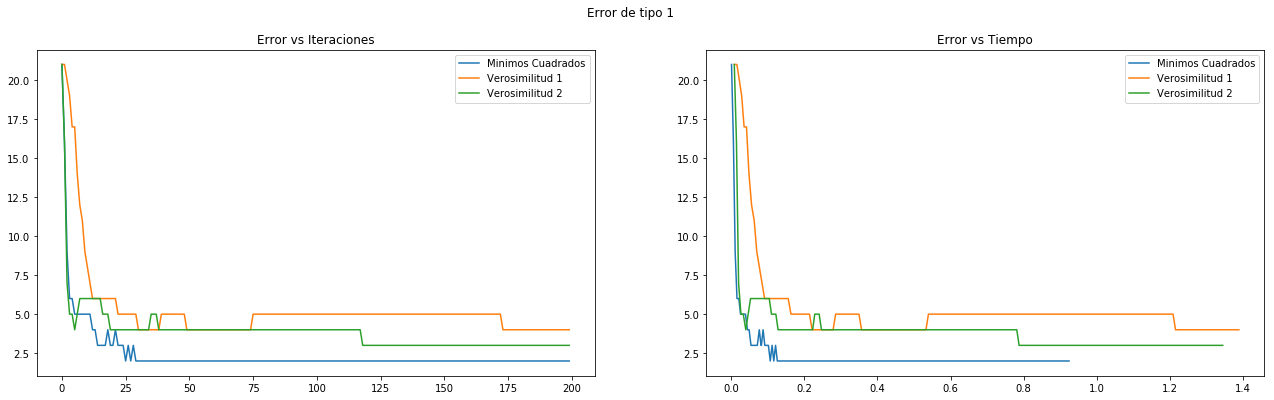

In [27]:
plot_error(err1, "Error de tipo 1")

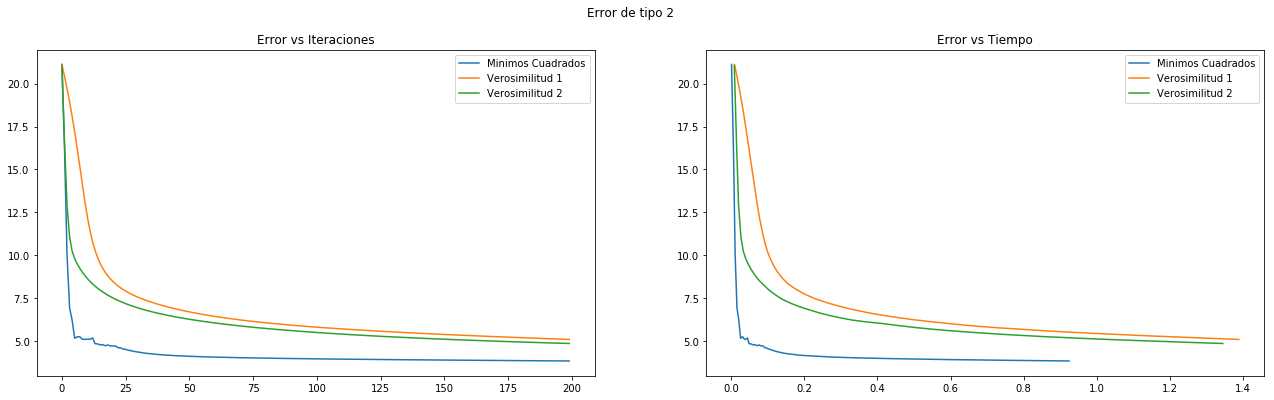

In [28]:
plot_error(err2, "Error de tipo 2")

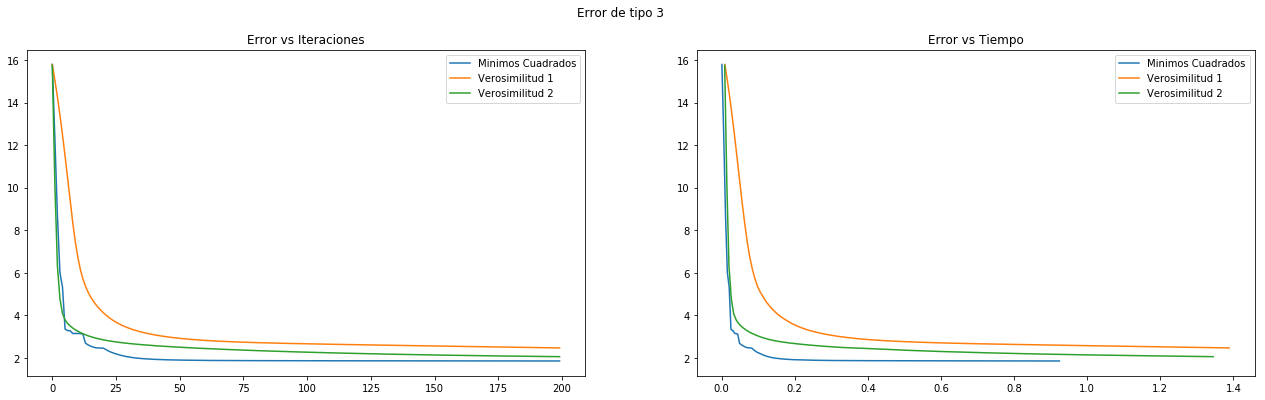

In [29]:
plot_error(err3, "Error de tipo 3")